In [1]:
from medmnist import BloodMNIST
import numpy as np
import pandas as pd
import torchvision.transforms as transforms

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = BloodMNIST(split="train", download=True, transform=data_transform)
test_dataset = BloodMNIST(split="test", download=True, transform=data_transform)

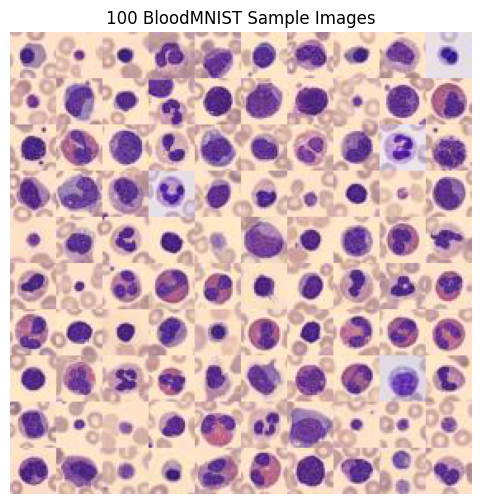

In [2]:
import matplotlib.pyplot as plt

# Use the built-in montage function to visualize the first 100 images
montage_img = train_dataset.montage(length=10)  # 10x10 grid 

# Plot the montage
plt.figure(figsize=(6,6)) # Set the figure size 
plt.imshow(montage_img) # Display the RGB montage image
plt.axis('off') # Hide axis ticks and labels
plt.title('100 BloodMNIST Sample Images') # Add plot title
plt.show() # Show plot

In [3]:
from medmnist import BloodMNIST
import numpy as np
import torch

# Get number of input channels by checking shape of one image after transform
# [0] gets (image, label); [0][0] gets the image tensor 
sample_tensor = train_dataset[0][0]  # Access the first sample, then get the image tensor
num_channels = sample_tensor.shape[0] # The first dimension is the number of channels

# Get label information
unique_labels = np.unique(train_dataset.labels) # Extract unique label values from the dataset
num_classes = len(unique_labels)  # Count how many unique labels 

# Dataset sizes
train_size = len(train_dataset) # Get total number of training samples
test_size = len(test_dataset) # Get total number of testing samples

# Print results
print("Number of input channels per image:", num_channels)
print("Unique labels:", unique_labels)
print("Number of classes:", num_classes)
print("Training dataset size:", train_size)
print("Testing dataset size:", test_size)

Number of input channels per image: 3
Unique labels: [0 1 2 3 4 5 6 7]
Number of classes: 8
Training dataset size: 11959
Testing dataset size: 3421


In [4]:
from medmnist import BloodMNIST
import numpy as np
import pandas as pd

# Extract labels
labels = train_dataset.labels.squeeze()

# Count and percentage for each class
unique, counts = np.unique(labels, return_counts=True)
total = counts.sum()
percentages = (counts / total) * 100

# Display result
df = pd.DataFrame({
    'Class': unique,
    'Count': counts,
    'Percentage': percentages
})
print(df)

   Class  Count  Percentage
0      0    852    7.124342
1      1   2181   18.237311
2      2   1085    9.072665
3      3   2026   16.941216
4      4    849    7.099256
5      5    993    8.303370
6      6   2330   19.483234
7      7   1643   13.738607


In [5]:
import torch                    
import torch.nn as nn          
import torch.nn.functional as F 

# Define a CNN model by creating a subclass of nn.Module
class CNNModel(nn.Module): # Inherit from PyTorch's base module class
    def __init__(self): # Constructor: defines the architecture of the model
        super(CNNModel, self).__init__() # Call the parent constructor to properly initialize the module

        # 1st convolutional layer:
        # This layer performs a 2D convolution on input data
        # Input: 3 channels (RGB image), Output: 16 filters (feature maps learned by the layer)
        # Kernel siz(size of the filter window): 3×3, Padding(Number of pixels to pad around the input.): 1 (to preserve 28×28 spatial dimensions)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)

        # 2nd convolutional layer:
        # Input: 16 channels from previous layer, Output: 32 channels
        # Kernel size: 3×3, Padding: 1 (preserve spatial dimensions before pooling)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)

        # 3rd convolutional layer:
        # Input: 32 channels, Output: 64 channels
        # Kernel size: 3×3, Padding: 1
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        # 4th convolutional layer:
        # Input: 64 channels, Output: 128 channels
        # Kernel size: 3×3, Padding: 1
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)

        # Max pooling layer to reduce spatial resolution
        # Kernel size: 2×2, Stride: 2 (halves the width and height each time)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layer:
        # Input: 128 channels from the last conv layer, spatial size is 1×1, 128 total values
        # Output: 9 units, one for each class (no softmax; CrossEntropyLoss will handle that)
        self.fc = nn.Linear(128 * 1 * 1, 8)

    def forward(self, x):  # Defines how the input data flows through the model
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 - ReLU activation - MaxPool (28x28 - 14x14)
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 - ReLU - MaxPool (14x14 - 7x7)
        x = self.pool(F.relu(self.conv3(x)))  # Conv3 - ReLU - MaxPool (7x7 - 3x3)
        x = self.pool(F.relu(self.conv4(x)))  # Conv4 - ReLU - MaxPool (3x3 - 1x1)
        
        x = x.view(x.size(0), -1) # Flatten the 4D tensor (batch, 128, 1, 1) - (batch, 128)
        x = self.fc(x) # Pass through the fully connected layer - (batch, 9)

        return x  # Output: logits (raw scores) for each of the 9 classes

# Instantiate the model
model = CNNModel()  # Create an instance of the CNN model


In [6]:
criterion = nn.CrossEntropyLoss()

In [7]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim

# Create data loaders for training and testing
# Batch size of 100 means each gradient update sees 100 examples

train_loader = DataLoader( # Create a data loader for the training dataset
    dataset=train_dataset, # Use training dataset
    batch_size=100,  # Number of samples per mini-batch
    shuffle=True  # Shuffle the data at every epoch for better generalization
)

test_loader = DataLoader( # Create a data loader for the testing dataset
    dataset=test_dataset, # Use testing dataset
    batch_size=100, # Same batch size for evaluation (shuffling not needed)
    shuffle=False  # Keep test data order fixed
)

# Instantiate the SGD optimizer
optimizer = optim.SGD(  # Use stochastic gradient descent as the optimization algorithm
    model.parameters(), # Pass in the model parameters to be updated
    lr=0.01 # Learning rate of 0.01 (step size for weight updates)
)


In [8]:
# Set model to training mode (enables dropout/batchnorm if present)
model.train()

# Train for 10 full passes through the dataset
for epoch in range(10):  # Loop over 10 epochs
    running_loss = 0.0   # Initialize variable to accumulate loss for this epoch

    for images, labels in train_loader: # Iterate over batches from training DataLoader
        labels = labels.squeeze()   # Fix shape for CrossEntropyLoss: (batch_size,)
        optimizer.zero_grad() # Reset gradients from previous step

        outputs = model(images) # Forward pass: compute model predictions (logits)
        loss = criterion(outputs, labels) # Compute loss between predictions and true labels

        loss.backward() # Backward pass: compute gradients of loss w.r.t. model parameters
        optimizer.step()  # Update model parameters using gradients

        running_loss += loss.item() # Accumulate batch loss

    # Print epoch summary
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")  # Display total loss for the epoch


Epoch 1, Loss: 246.2646
Epoch 2, Loss: 242.2845
Epoch 3, Loss: 239.1148
Epoch 4, Loss: 235.8959
Epoch 5, Loss: 225.2491
Epoch 6, Loss: 190.8920
Epoch 7, Loss: 160.2546
Epoch 8, Loss: 147.8400
Epoch 9, Loss: 141.9807
Epoch 10, Loss: 135.0481


In [9]:
import torch
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    accuracy_score
)

# Set model to evaluation mode
model.eval()

# Store outputs and labels
all_outputs = []
all_labels = []

# Disable gradient tracking
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)  # Raw logits
        all_outputs.append(outputs)
        all_labels.append(labels.squeeze())  # Shape (batch_size,)

# Concatenate predictions and labels
y_score = torch.cat(all_outputs, dim=0).numpy()  
y_true = torch.cat(all_labels, dim=0).numpy()    

# Binarize true labels for AUC calculation
y_true_bin = label_binarize(y_true, classes=np.arange(8))  # Shape (N, 9)

# Per-class AUC with handling of missing classes
class_auc = []
for i in range(8):
    y_true_i = y_true_bin[:, i]
    y_score_i = y_score[:, i]

    if np.unique(y_true_i).size < 2:
        print(f"Skipping class {i}: only one label present in ground truth.")
        class_auc.append(None)
        continue

    auc = roc_auc_score(y_true_i, y_score_i)
    class_auc.append(auc)
    print(f"AUC for class {i}: {auc:.4f}")

# Predicted class labels
y_pred = np.argmax(y_score, axis=1)

# Overall accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {acc:.4f}")

# Classification report
report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:")
print(report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)


AUC for class 0: 0.8626
AUC for class 1: 0.7422
AUC for class 2: 0.7690
AUC for class 3: 0.8084
AUC for class 4: 0.9322
AUC for class 5: 0.8626
AUC for class 6: 0.6987
AUC for class 7: 0.9995
Overall Accuracy: 0.5609
Classification Report:
              precision    recall  f1-score   support

           0     0.2250    0.6926    0.3397       244
           1     0.9394    0.1490    0.2573       624
           2     0.8256    0.5177    0.6364       311
           3     0.4127    0.4698    0.4394       579
           4     0.7256    0.6420    0.6812       243
           5     0.3750    0.0211    0.0400       284
           6     0.5961    0.9174    0.7226       666
           7     0.9783    0.9596    0.9689       470

    accuracy                         0.5609      3421
   macro avg     0.6347    0.5462    0.5107      3421
weighted avg     0.6654    0.5609    0.5289      3421

Confusion Matrix:
[[169   0   0  66   5   1   3   0]
 [173  93   0 150   2   4 202   0]
 [ 25   0 161   7  32

In [10]:
import numpy as np
unique_labels = np.unique(train_dataset.labels)
print("Unique training labels:", unique_labels)

unique_test_labels = np.unique(test_dataset.labels)
print("Unique test labels:", unique_test_labels)

print("y_score shape:", y_score.shape)
print("Max predicted class:", np.argmax(y_score, axis=1).max())


Unique training labels: [0 1 2 3 4 5 6 7]
Unique test labels: [0 1 2 3 4 5 6 7]
y_score shape: (3421, 8)
Max predicted class: 7
